the plan will be to run use half a session to predict tuning (goal progress, speed, position, etc) for a neuron, use that as predictors for the other half and calculate the coefficient of partial determination for each predictor
Predictors to consider:
- LMs (entry timing and identity)
- position bins
- goal progress bins
- task state (ABCD) bins
- latent state (lap 1,2,3)
- rewards - does it make sense to convolve this with a kernel?
- licks - does it make sense to convolve this with a kernel?
- running speed bins

Steps this script will need to do:
- make a selection of frames or laps to consider as training data (behaviour and imaging)
- create a design matrix from the training data
- fit a log reg model 
- predict test set 
- calculate SSE
- select a predictor (group) to remove from the model, 
- calculate CPD (SSEi - SSEfull)/SSEi 

# Testing GLM functions - GLM per cell per session

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks
from barcode import barcode_util
from barcode import extract_barcodes
import pickle
import parse_session_functions
from suite2p.extraction import dcnv
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
import matplotlib.patches as patches
import cellTV_functions as cellTV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
#suppress the warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
#load the files
base_path = '/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2/'
mouse = 'TAA0000066'
stage = 't12'

imaging_path, config_path, frame_ix, date1, date2 = cellTV.get_session_folders(base_path,mouse,stage)
f, fneu, iscell, ops, seg, frame_rate = cellTV.load_img_data(imaging_path)
dF = cellTV.get_dff(f, fneu, frame_ix, ops)
# Load the behavior data
if stage in ['-t3','-t4','-t5', '-t6']:
    session = parse_session_functions.analyse_npz_pre7(mouse, date2, plot=False)
else:
    session = parse_session_functions.analyse_npz(mouse,date2,plot=False)

Calculated dF/F with the following parameters: baseline=maximin, win_baseline=60.0, sig_baseline=10.0, fs=45,perctile_baseline=8.0
Training and Imaging
Performance =  0.7336947278911565
Number of laps =  109


In [3]:
#build a design matrix for a given frame range by creating the full range of frames and subselecting the relevant frames from the dF matrix
frame_range = np.arange(dF.shape[1])  # Use the full range of frames
predictors = {}

#decide on parameters that should be included, comment out the ones you don't want
params = {
    'position': True,
    'landmarks': True,
    'goal_progress': True,
    'task_state': True,
    'latent_state': True,
    'licks': True,
    'rewards': True,
    'speed': True
}

#extract the design matrix
if params['position']:
    position = session['position']
    #bin the position data and create a vector for each bin that is 1 if the animal was in that bin, 0 otherwise
    bins_pos = 100
    if stage in ['-t3', '-t4', '-t5', '-t6']:
        bin_edges = np.linspace(0, session['position'].max(), bins_pos+1)
    else:
        bin_edges = np.linspace(9, session['position'].max(), bins_pos+1)
    bin_indices = np.digitize(position, bin_edges) - 1  # -1 to make it zero-indexed
    position_vectors = np.zeros((len(frame_range), len(bin_edges)-1))
    for i in range(bins_pos):
        pos_frames = np.where(bin_indices == i)[0]
        # Ensure pos_frames are within the range of frame_range
        position_vectors[pos_frames, i] = 1
    # Add the position vector to the predictors dictionary
    predictors['position'] = position_vectors

if params['landmarks']:
    num_lms = len(np.unique(session['lm_idx']))-1  # Exclude the 'no landmark' category
    lm_vectors = np.zeros((len(frame_range), num_lms))
    for i in range(num_lms):
        lm_frames = np.where(session['lm_idx'] == i+1)[0]
        # Ensure lm_frames are within the range of frame_range
        lm_vectors[lm_frames, i] = 1
    # Add the landmark vectors to the predictors dictionary
    predictors['landmarks'] = lm_vectors

if params['goal_progress']:
    #first bin times between rewards into n bins
    bins_goal = 9
    reward_ix = session['rewards']
    goal_vec = []
    goal_progress = np.zeros((len(frame_range), bins_goal))
    for i in range(len(reward_ix)-1):
        phase_frames = np.arange(reward_ix[i], reward_ix[i+1]-1)
        # Ensure phase_frames are within the range of frame_range
        bin_edges = np.linspace(reward_ix[i], reward_ix[i+1]-1, bins_goal+1)
        bin_ix = np.digitize(phase_frames, bin_edges)

        for j in range(bins_goal):
            goal_frames = np.where(bin_ix == j+1)[0]
            target_frames = phase_frames[goal_frames]
            goal_progress[target_frames, j] = 1

    predictors['goal_progress'] = goal_progress

if params['task_state']:
    reward_ix = session['rewards']
    num_states = len(np.unique(session['goal_idx']))
    state_id_vec = np.arange(num_states)
    state_id_vec = np.tile(state_id_vec, len(session['rewards'])//num_states)
    state_id_vec = state_id_vec[:-1]

    task_state = np.zeros((len(frame_range), num_states))
    for i in range(num_states):
        state_frames = np.where(state_id_vec == i)[0]
        # Ensure state_frames are within the range of frame_range
        state_on = reward_ix[state_frames]
        state_off = reward_ix[state_frames + 1]-1 if np.all(state_frames + 1 < len(reward_ix)) else reward_ix[state_frames[:-1]] + 1
        if len(state_off) < len(state_on):
            #add a last state_off if it is missing
            state_off = np.append(state_off, frame_range[-1])
        for j in range(len(state_on)):
            task_state[state_on[j]:state_off[j], i] = 1
    # Add the task state vector to the predictors dictionary
    predictors['task_state'] = task_state
        
if params['latent_state']:
    # Assuming latent states are defined by the session['latent_state'] variable
    num_latent_states = len(np.unique(session['state_id']))
    latent_state = np.zeros((len(frame_range), num_latent_states))
    for i in range(session['num_laps']):
        lap_frames = np.where(session['lap_idx'] == i)[0]
        for j in range(num_latent_states):
            if session['state_id'][i] == j:
                # Set the latent state for the frames in this lap
                latent_state[lap_frames, j] = 1
    # Add the latent state vector to the predictors dictionary
    predictors['latent_state'] = latent_state

if params['licks']:
    # Assuming licks are defined by the session['licks'] variable
    lick_frames = np.zeros((len(frame_range), 1))
    lick_times = session['licks']
    for lick in lick_times:
        if lick < frame_range[-1] and lick >= frame_range[0]:
            lick_frames[lick, 0] = 1
    # Add the lick vector to the predictors dictionary
    predictors['licks'] = lick_frames

if params['rewards']:
    # Assuming rewards are defined by the session['rewards'] variable
    reward_frames = np.zeros((len(frame_range), 1))
    reward_times = session['rewards']
    for reward in reward_times:
        if reward < frame_range[-1] and reward >= frame_range[0]:
            reward_frames[reward, 0] = 1
    # Add the reward vector to the predictors dictionary
    predictors['rewards'] = reward_frames

if params['speed']:
    # Assuming speed is defined by the session['speed'] variable
    speed = session['speed']
    # Bin the speed data into 10 bins
    bins_speed = 10
    bin_edges = np.linspace(0, speed.max(), bins_speed+1)
    bin_indices = np.digitize(speed, bin_edges) - 1  # -1 to make it zero-indexed
    speed_vectors = np.zeros((len(frame_range), bins_speed))
    for i in range(bins_speed):
        speed_frames = np.where(bin_indices == i)[0]
        #if speed frames are within the range of frame_range, set them to 1
        if len(speed_frames) > 0:
            speed_vectors[speed_frames, i] = 1
    # Add the speed vector to the predictors dictionary
    predictors['speed'] = speed_vectors


In [5]:
#print the dimensions of the predictors
for key, value in predictors.items():
    print(f"{key}: {value.shape}")

position: (121277, 100)
landmarks: (121277, 10)
goal_progress: (121277, 9)
task_state: (121277, 4)
latent_state: (121277, 3)
licks: (121277, 1)
rewards: (121277, 1)
speed: (121277, 10)


In [16]:
100+10+9-1

118

Text(0.5, 1.0, 'Design Matrix')

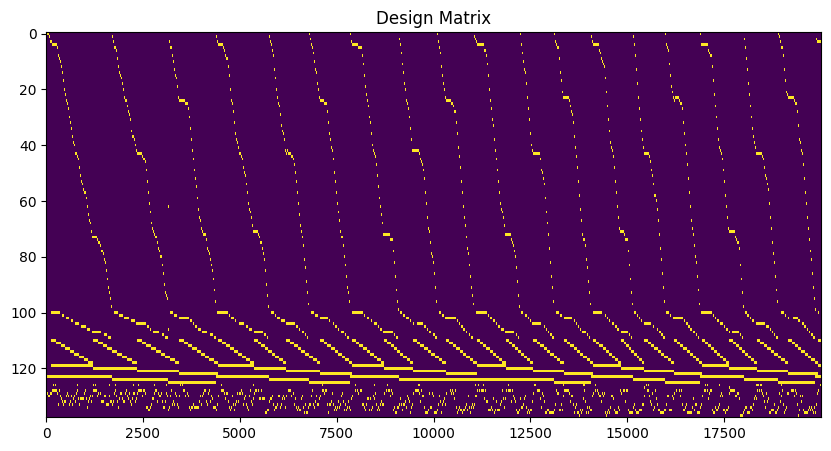

In [6]:
#build one big design matrix from all predictors
design_matrix = np.hstack([predictors[key] for key in predictors.keys() if key in params and params[key]])
plt.figure(figsize=(10, 5))
plt.imshow(design_matrix[:20000].T, aspect='auto', cmap='viridis', interpolation='none')
plt.title('Design Matrix')

R^2 score for cell 501: 0.0870
Highest 10 coefficients: [ 69 103 121  36 120 102  72 107 110  71]
Lowest 5 coefficients: [127 137  26 134  28]


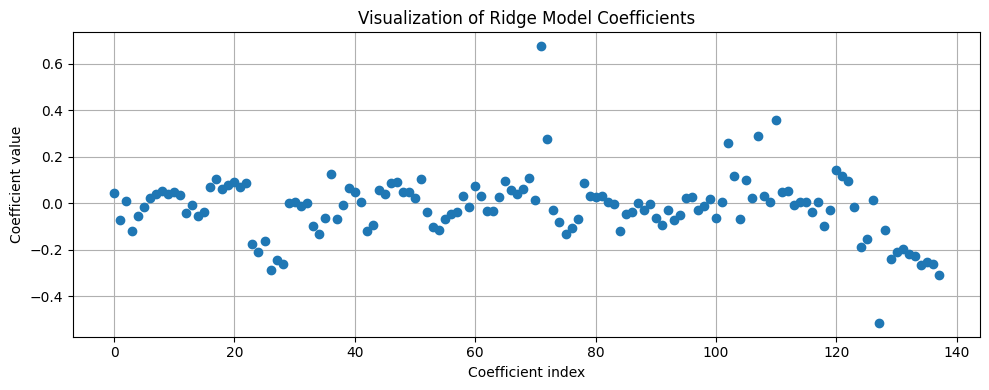

In [17]:
cell = 501
# Extract the dF for the selected cell
dF_cell = dF[cell, frame_range]
# zscore the dF data
dF_cell = (dF_cell - np.mean(dF_cell)) / np.std(dF_cell)

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(design_matrix, dF_cell, test_size=0.2, random_state=42)
# Fit a linear regression model
model = Ridge(alpha=1)
model.fit(X_train, y_train)
# Predict the dF for the test set
y_pred = model.predict(X_test)
# Calculate the R^2 score
r2_score = model.score(X_test, y_test)
print(f"R^2 score for cell {cell}: {r2_score:.4f}")

#plot the coefficients of the model as scatter plot
# Visualize the coefficients in a graph
plt.figure(figsize=(10, 4))
plt.plot(model.coef_, marker='o', linestyle='')
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.title('Visualization of Ridge Model Coefficients')
plt.tight_layout()  # Adjust the layout to avoid overlap
plt.grid(True)

print(f"Highest 10 coefficients: {np.argsort(model.coef_)[-10:]}")
print(f"Lowest 5 coefficients: {np.argsort(model.coef_)[:5]}")


In [59]:
r2_score = np.zeros(dF.shape[0])  # Initialize an array to store R^2 scores for each cell
for cell in range(dF.shape[0]):
    # Extract the dF for the selected cell
    dF_cell = dF[cell, frame_range]
    # zscore the dF data
    dF_cell = (dF_cell - np.mean(dF_cell)) / np.std(dF_cell)

    #split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(design_matrix, dF_cell, test_size=0.2, random_state=42)
    # Fit a linear regression model
    model = Ridge(alpha=1)
    model.fit(X_train, y_train)
    # Predict the dF for the test set
    y_pred = model.predict(X_test)
    # Calculate the R^2 score
    r2_score[cell] = model.score(X_test, y_test)


In [60]:
print(f'The best 5 predicted cells: {np.argsort(r2_score)[-5:]}')

The best 5 predicted cells: [302  33 215 481 400]


Text(0.5, 0, 'R^2 Score')

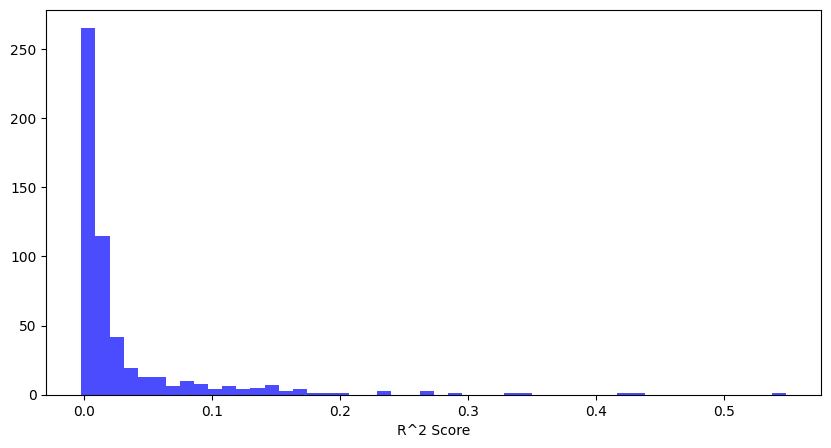

In [53]:
plt.figure(figsize=(10, 5))
plt.hist(r2_score, bins=50, color='blue', alpha=0.7)
plt.xlabel('R^2 Score')